In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
%matplotlib inline

In [2]:
def K(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [3]:
def STA(r, x, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

In [4]:
def Ay(k,g,alpha,beta,sigma_c, sigma_h,x,n = 1000):
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

In [5]:
sigma_h = 1# RF size of horizontal cell
sigma_c = sigma_h*2/3# RF size of cone cell
gamma = 1/(sigma_c**2)
klen = 2*sigma_h# half of width of horizontal kernal
dx = 0.01*sigma_h
##Create spatial kernal
klen = sigma_h*3
xx = np.arange(-klen,klen,dx)

KC = K(xx,sigma_c)
KH = K(xx,sigma_h)
KKK = K(xx, dx*10)
 
dt=0.01
T = np.arange(100)*dt
tau_y = 0.02
Ky=T/tau_y/tau_y*np.exp(-T/tau_y)

In [6]:
#Width setting
xlen = 20*sigma_h #spatial extend of simulation
hw = 0.75*sigma_h#half bar width
tempx = np.arange(0,xlen,dx)

In [7]:
alpha = 1/0.024
beta = 1./1.
k = alpha*0.5
phi = 1.
g = beta

g*k*phi/alpha/beta

0.5

Text(0.5, 1.0, 'Show Analitc Solution of Steady State')

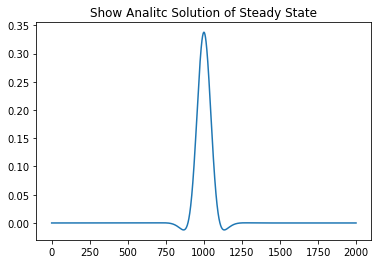

In [8]:
x = np.arange(-int(xlen/dx/2),int(xlen/dx/2))*dx
plt.plot(Ay(k,g,alpha,beta,sigma_c, sigma_h,x))
plt.title('Show Analitc Solution of Steady State')

## Whole Field STA

In [9]:
nstep = 5000

y = np.zeros(int(xlen/dx)) # cone cell output
z = np.zeros(int(xlen/dx)) # horizontal cell output
ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)



stm = np.zeros([int(xlen/dx),nstep])#input
rsp = np.zeros([int(xlen/dx),nstep])#y output
zts = np.zeros([int(xlen/dx),nstep])#horizontal

x = np.random.randn(nstep+99)*0.3+1
T = np.arange(100)*dt
tau_y = 0.02
Ky=T/tau_y/tau_y*np.exp(-T/tau_y)
sx = np.convolve(x,Ky,'valid')*dt

for i in range(nstep):
    s = np.ones(int(xlen/dx))*sx[i]
    rs = np.convolve(s,KC,'same')*dx
    
    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
    y = (y+dyj)
    z = (z+dzj)

    ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

    stm[:,i] = s
    rsp[:,i] = y
    zts[:,i] = z
    

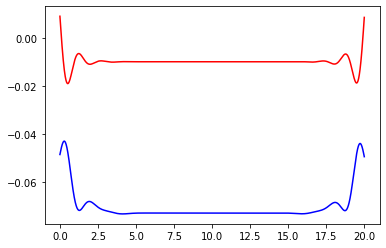

In [10]:
#####PLot numerical solution########
plt.plot(tempx,y,'b')#numerical solution
plt.plot(tempx,-z,'r')#numerical solution

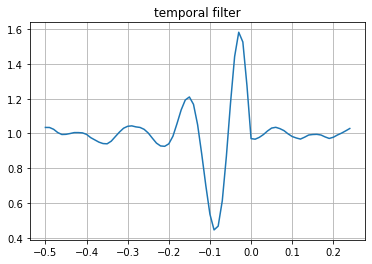

In [11]:
output = rsp[int(xlen/dx/2),:]
time, xSTA = STA(output, x[99:], dt, [-0.5,0.25])
plt.plot(time, xSTA)
plt.title('temporal filter')
plt.grid()

## A Smooth Constant speed Moving Bar

In [12]:
nstep = 1600
moving_bar = np.zeros([nstep, int(xlen/dx)])
pos = 0
v = 0.5 #dx/step
hw = 10 #dx
pos = 600
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos+v
    moving_bar[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1
    speak[i] = pos*dt

In [13]:
y = np.zeros(int(xlen/dx)) # cone cell output
z = np.zeros(int(xlen/dx)) # horizontal cell output
ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

sstm = np.zeros([nstep,int(xlen/dx)])#smoothed input
rsp = np.zeros([int(xlen/dx),nstep])#y output
zts = np.zeros([int(xlen/dx),nstep])#horizontal
rpeak = np.zeros(nstep)

for j in range(0, int(xlen/dx)):
    for i in range(len(Ky)-1):
        for ii in range(i):
            sstm[i,j] += moving_bar[ii,j]*Ky[i-ii]*dt

    sx = np.convolve(moving_bar[:,j],Ky,'valid')*dt
    sstm[99:,j] = sx.copy()

for i in range(nstep):
    s = sstm[i,:]
    rs = np.convolve(s,KC,'same')*dx
    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
    y = (y+dyj)
    z = (z+dzj)

    ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)
    
    maxpos = np.argmax(y)
    rpeak[i]= maxpos*dx
    rsp[:,i] = y
    zts[:,i] = z

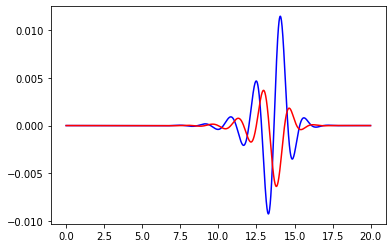

In [14]:
#####PLot numerical solution########
plt.plot(tempx,y,'b')#numerical solution
plt.plot(tempx,-z,'r')#numerical solution

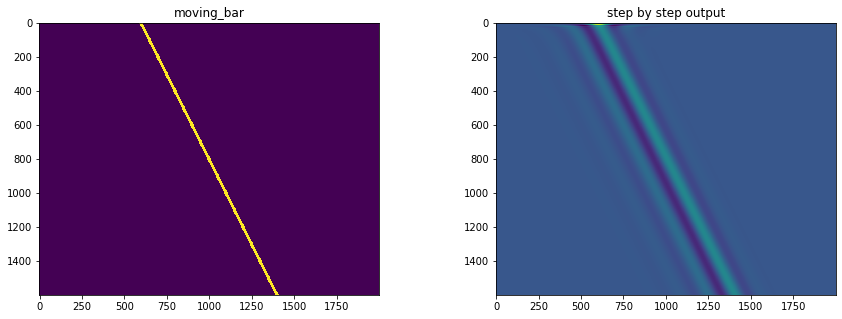

In [15]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(rsp.T)
sbs_y = rsp.T
ax3.set_title('step by step output')
fig.set_size_inches(15, 5)

Text(0.5, 1.0, 'prediction')

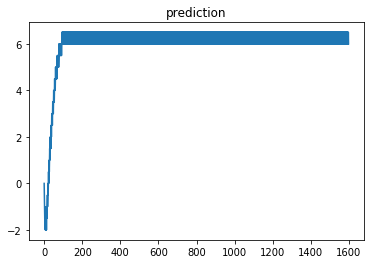

In [16]:
plt.plot(((rpeak-speak)/dx)[1:])
# plt.xlim([100,nstep])
# plt.ylim([-hw,+hw])
plt.title('prediction')

## spatial-temporal Checker 

In [17]:
nstep = 500000

y = np.zeros(int(xlen/dx)) # cone cell output
z = np.zeros(int(xlen/dx)) # horizontal cell output
ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

stm = np.zeros([int(xlen/dx),nstep])#input
sstm = np.zeros([int(xlen/dx),nstep])#smoothed input
rsp = np.zeros([int(xlen/dx),nstep])#y output
# zts = np.zeros([int(xlen/dx),nstep])#horizontal


for j in range(0, int(xlen/dx)):
    x = np.random.randn(nstep+99)*0.3+1
    stm[j,:] = x[99:].copy()
    sx = np.convolve(x,Ky,'valid')*dt
    sstm[j,:] = sx.copy()

for i in range(nstep):
    s = sstm[:,i]
    rs = np.convolve(s,KC,'same')*dx
    
    dyj =(-alpha*y+k*(rs-phi*rz))*dt
    dzj =(-beta*z+g*y)*dt
    y = (y+dyj)
    z = (z+dzj)

    ry = np.convolve(y,KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    rz = np.convolve(z,KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)
    
    rsp[:,i] = y
#     zts[:,i] = z

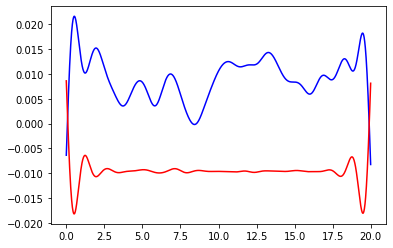

In [18]:
#####PLot numerical solution########
plt.plot(tempx,y,'b')#numerical solution
plt.plot(tempx,-z,'r')#numerical solution

In [19]:
output = rsp[int(xlen/dx/2),:]
time, xSTA = STA(output, stm[0,:], dt, [-0.4,0.25])
test = xSTA[:, np.newaxis]
for j in range(1, int(xlen/dx)):
    _, xSTA = STA(output, stm[j,:], dt, [-0.4,0.25])
    test = np.concatenate((test, xSTA[:, np.newaxis]), axis=1)

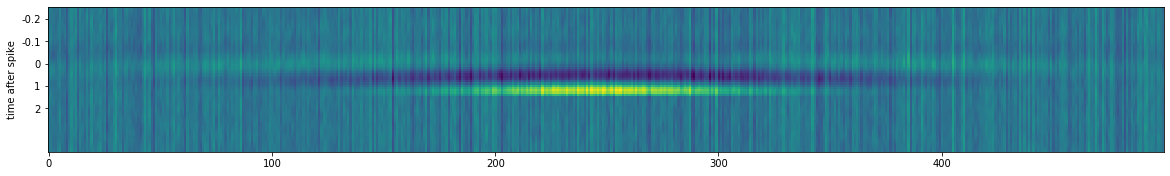

In [20]:
fig, ax = plt.subplots(1,1)
ax.imshow(test[:,750:1250])
ax.set_ylabel('time after spike')
ax.set_yticks(np.arange(5,50,10))
ax.set_yticklabels(['-0.2','-0.1','0','1','2'])
# ax.set_xticks(np.arange(300,701,100))
# ax.set_xticklabels(['-200','-100','0','100','200'])
# ax.set_xlabel('distance from the cell')
# ax.set_xlim([300, 701])
fig.set_size_inches(20, 5)

choose center cell and a certain time before spike

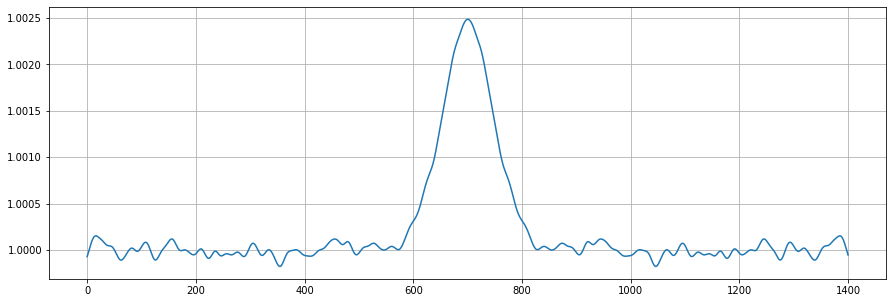

In [21]:
tbs_i = 39
plt.plot(np.convolve((test[tbs_i, :]+np.flip(test[tbs_i, :]))/2,KKK,'valid')*dx)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15, 5)

In [22]:
ST_kernel = []
for i in np.arange(15,41):
    ST_kernel.append(np.convolve((test[i, :]+np.flip(test[i, :]))/2,KKK,'valid')*dx)
ST_kernel = np.array(ST_kernel)
ST_kernel = np.flipud(ST_kernel)-1

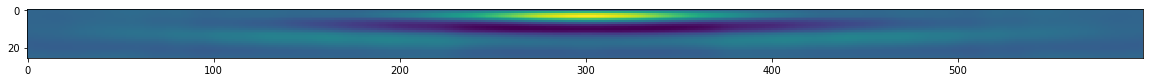

In [23]:
plt.imshow(ST_kernel[:,400:1000])
fig = plt.gcf()
fig.set_size_inches(20, 5)

## Simply apply spatial-temporal kernel on moving bar

In [24]:
tic = toc.time()
nstep = 1600
mb_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y[i,:] += np.convolve(moving_bar[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

10.334367275238037

In [25]:
# STK = np.concatenate((np.zeros_like(ST_kernel),ST_kernel), axis = 0)
# np.shape(STK)
# tic = toc.time()
# nstep = 1600
# con2d_y = signal.convolve2d(moving_bar, STK,  mode='same')
# print(toc.time()-tic)
# plt.imshow(con2d_y)

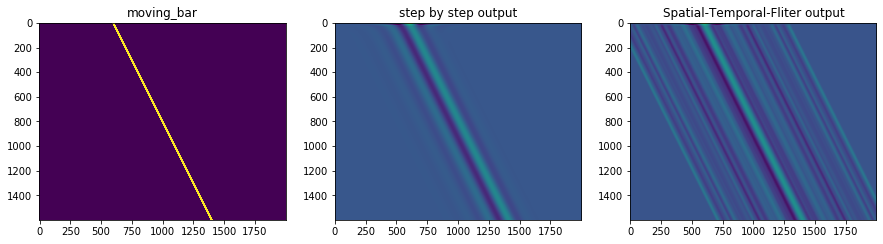

In [26]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(sbs_y)
ax3.set_title('step by step output')
ax4.imshow(mb_y)
ax4.set_title('Spatial-Temporal-Fliter output')
fig.set_size_inches(15, 5)

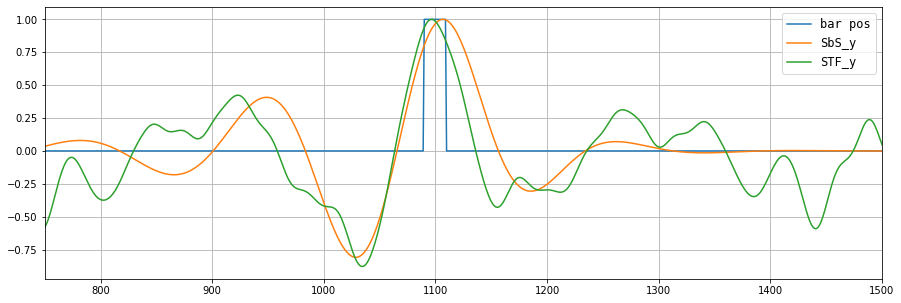

In [28]:
plt.plot(moving_bar[1000,:])
plt.plot(sbs_y[1000,:]/max(sbs_y[1000,:]))
plt.plot(mb_y[1000,:]/max(mb_y[1000,:]))
# plt.plot(con2d_y[1000,:]/max(con2d_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'con2d_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([750,1500])
fig.set_size_inches(15, 5)

## Apply SVD on Spatial-Temporal Kernel

In [29]:
from numpy import linalg as la
U,sigma,VT=la.svd(ST_kernel)

In [30]:
sigma/sum(sigma)

array([5.64809850e-01, 2.25954244e-01, 1.02388476e-01, 6.06599973e-02,
       2.11921465e-02, 7.90396060e-03, 5.26715543e-03, 2.41629776e-03,
       1.90502503e-03, 1.58460632e-03, 1.03219876e-03, 8.92698587e-04,
       6.39356749e-04, 5.53088177e-04, 4.28376406e-04, 3.87074191e-04,
       3.01085627e-04, 2.63380236e-04, 2.53240896e-04, 2.25161193e-04,
       2.10578933e-04, 1.88548796e-04, 1.63130770e-04, 1.46456643e-04,
       1.27322090e-04, 1.06542819e-04])

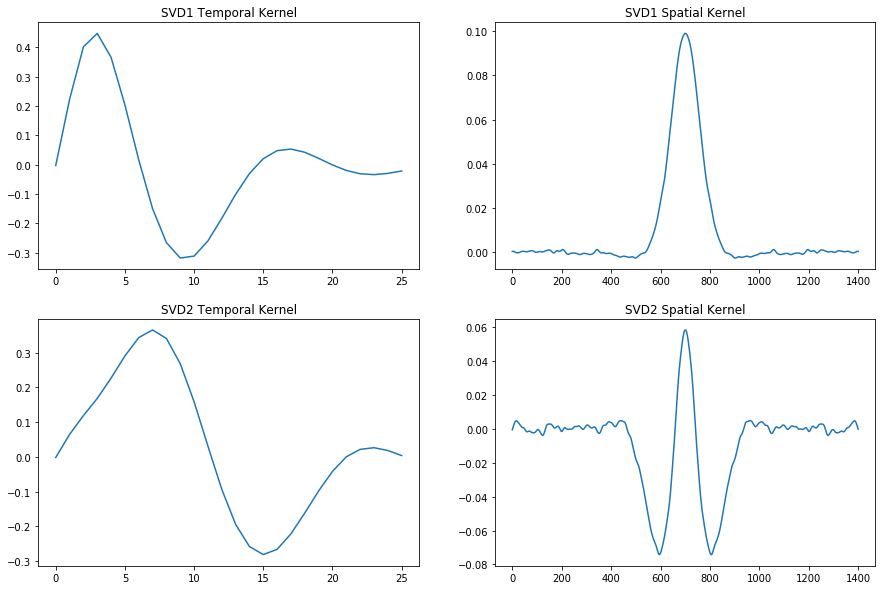

In [31]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

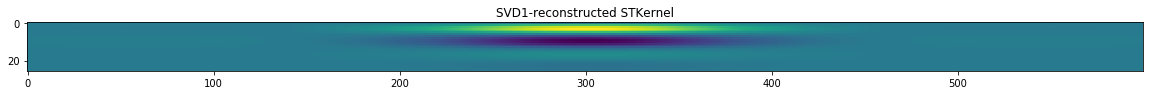

In [36]:
cSVD = 0
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel[:,400:1000])
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

In [37]:
nstep = 1600
SVD_STK_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in range(i):
        if (i-ii) < np.shape(ST_kernel)[0]:
            SVD_STK_y[i,:] += np.convolve(moving_bar[ii,:],SVD_STkernel[i-ii, :], 'same')

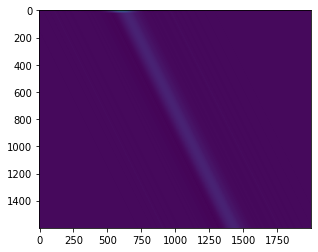

In [38]:
plt.imshow(SVD_STK_y)

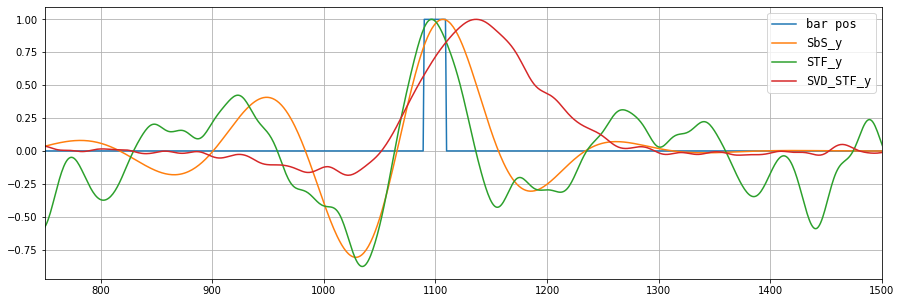

In [39]:
plt.plot(moving_bar[1000,:])
plt.plot(sbs_y[1000,:]/max(sbs_y[1000,:]))
plt.plot(mb_y[1000,:]/max(mb_y[1000,:]))
plt.plot(SVD_STK_y[1000,:]/max(SVD_STK_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'SVD_STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([750,1500])
fig.set_size_inches(15, 5)

In [41]:
del sstm